In [1]:
from sdv.demo import load_timeseries_demo
import pandas as pd

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./AAPL Historical Data.csv')

In [3]:
data.head()

,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17


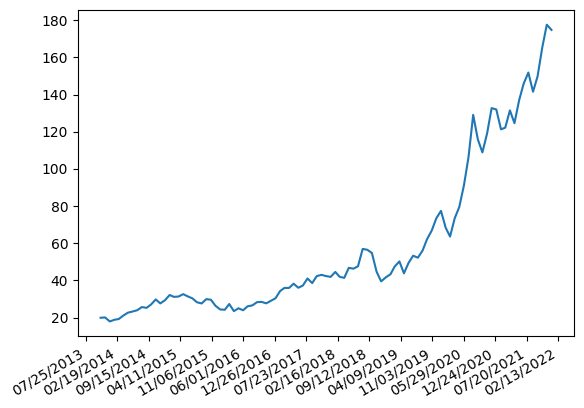

In [4]:
import matplotlib as plt
dates = list(data['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
y = list(data['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [5]:
from sdv.timeseries import PAR


In [ ]:
context_columns = ['Price']

In [6]:
model = PAR(
  )

In [7]:
model.fit(data)

In [12]:
data_new = model.sample()

In [13]:
data_new = pd.DataFrame(data_new)

In [14]:
data_new['Date'] =pd.to_datetime(data_new.Date)
data_new = data_new.sort_values(by='Date')
data_new.to_csv('new.csv')

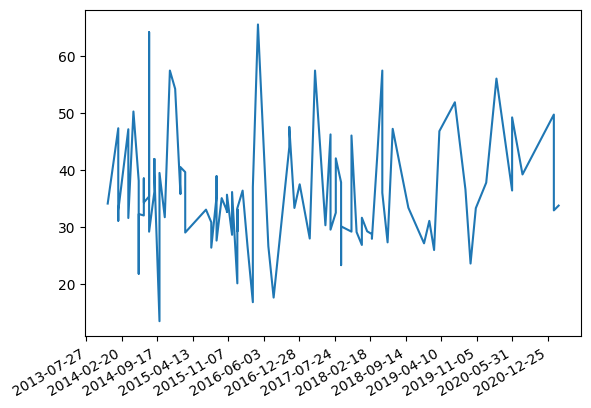

In [15]:
import matplotlib as plt
data_new = pd.read_csv('new.csv')
dates = list(data_new['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data_new['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()